In [1]:
import numpy as np
import pandas as pd
import tqdm as tqdm

X_train = pd.read_csv('./data/X_train')
Y_train = pd.read_csv('./data/Y_train')

In [2]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54256 entries, 0 to 54255
Columns: 511 entries, id to  95
dtypes: int64(511)
memory usage: 211.5 MB


In [3]:
Y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54256 entries, 0 to 54255
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      54256 non-null  int64
 1   label   54256 non-null  int64
dtypes: int64(2)
memory usage: 847.9 KB


In [4]:
# 正负样本比例
Y_train.groupby('label').count()/Y_train.shape[0]

,id
label,
0,0.794474
1,0.205526


In [5]:
# 数据处理
def _normalize(X):
    return (X - X.mean())/ (X.std() + 1e-8)

def _shuffle(X, y):
    n_sample = X.shape[0]
    n_range = np.arange(n_sample)
    np.random.shuffle(n_range)
    return X[n_range], y[n_range]

def _train_data_split(X, y, split_ratio=0.2):
    n_sample = X.shape[0]
    n_threshold = int(n_sample*split_ratio)
    
    return X[:n_threshold], y[:n_threshold], X[n_threshold:], y[n_threshold:]
    

In [6]:
# 构造函数
def _sigmoid(z):
    return np.clip(1 / (1 + np.exp(-z)), 1e-8, 1)

def _f(X, w, b):
    z = np.matmul(X, w) + b
    return _sigmoid(z)

def _predict(X, w, b):
    return np.round(_f(X, w, b)).astype(np.int)

def _accuracy(y_true, y_pred):
    return 1 - np.mean(np.abs(y_true - y_pred))


In [21]:
# 梯度下降
def cross_entropy_loss(y_true, y_pred):
    n_sample = y_pred.shape[0]
    return (y_true.dot(np.log(y_pred + 1e-8)) + (1 - y_true).dot(np.log(1 - y_pred  + 1e-8))) / -n_sample

def _gradient(X, y_pred, y_true):
    n_sample = y_pred.shape[0]
    error = y_true - y_pred
    w_grad = X.T.dot(error) / -n_sample
    b_grad = np.ones(n_sample).reshape(1, -1).dot(error) / -n_sample
    return w_grad, b_grad
    

In [8]:
X_train = _normalize(X_train).values
Y_train = Y_train['label'].values

X_train, Y_train, X_test, Y_test = _train_data_split(X_train, Y_train, split_ratio=0.2)

In [22]:
n_iter = 100
batch_size = 50
learning_rate = 0.2

w = np.ones(X_train.shape[1])
b = 0
step = 1
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
for epoch in range(n_iter):
    X_train, Y_train = _shuffle(X_train, Y_train)
    
    for i in range(int(np.floor(X_train.shape[0]/batch_size))):
        X = X_train[i*batch_size:(i+1)*batch_size, :]
        y_true = Y_train[i*batch_size:(i+1)*batch_size]
        
        y_pred = _f(X, w, b)
        
#         loss = cross_entropy_loss(y_pred, y_true)
        
        w_grad, b_grad = _gradient(X, y_pred, y_true)
        
        w -= learning_rate / np.sqrt(step) * w_grad
        b -= learning_rate / np.sqrt(step) * b_grad
        
        step += 1
    Y_pred = _f(X_train, w, b)
    train_loss_list.append(cross_entropy_loss(Y_train, Y_pred))
    train_accuracy_list.append(_accuracy(Y_train, _predict(X_train, w, b)))
    
    Y_pred = _f(X_test, w, b)
    test_loss_list.append(cross_entropy_loss(Y_test, Y_pred))
    test_accuracy_list.append(_accuracy(Y_test, _predict(X_test, w, b))) 
        
print('Train Loss:{} Accuracy:{}'.format(train_loss_list[-1], train_accuracy_list[-1]))
print('Test Loss:{} Accuracy:{}'.format(test_loss_list[-1], test_accuracy_list[-1]))

Train Loss:0.3481210616317753 Accuracy:0.8814855773661414
Test Loss:1.3409770349982166 Accuracy:0.6679875590369773


In [23]:
Y_pred

array([1.00000000e-08, 1.71711638e-01, 1.87754740e-01, ...,
       2.85462542e-07, 9.95701854e-01, 5.29407840e-01])

In [24]:
Y_pred

array([1.00000000e-08, 1.71711638e-01, 1.87754740e-01, ...,
       2.85462542e-07, 9.95701854e-01, 5.29407840e-01])

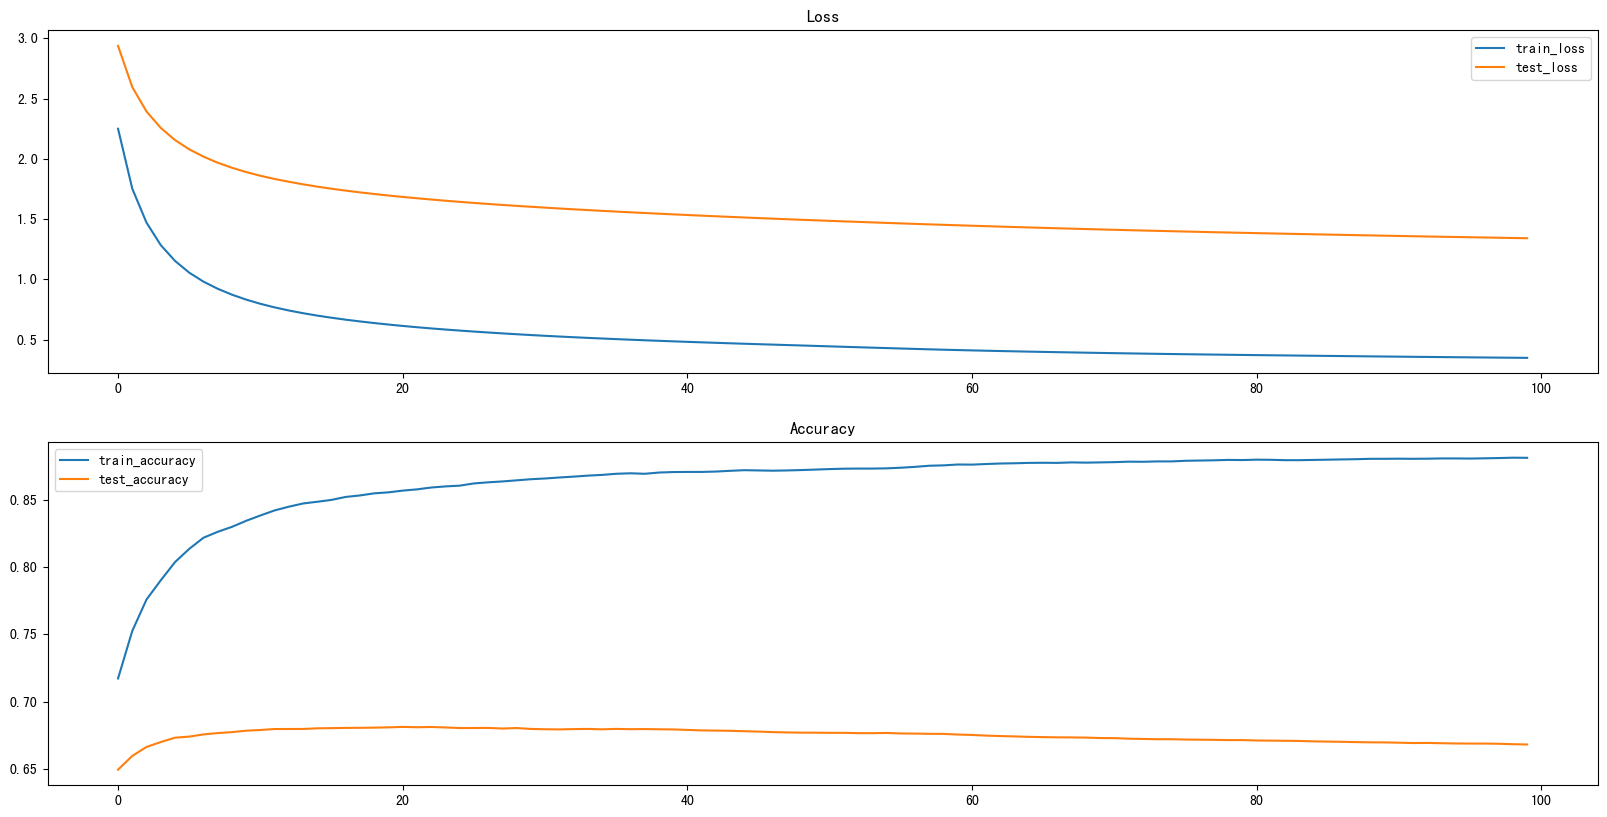

In [25]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10), dpi=100)
plt.subplot(2, 1, 1)
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.title('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(train_accuracy_list, label='train_accuracy')
plt.plot(test_accuracy_list, label='test_accuracy')
plt.title('Accuracy')
plt.legend()

In [26]:
fig.savefig('损失函数图像')